In [ ]:
import random
import numpy as np                          # library for scientific computing and matrix operations
import nltk                                 # NLP toolbox
from os import getcwd
import pandas as pd                         # Library for Dataframes 
from nltk.corpus import twitter_samples     # loading twitter_samples from nltk library
import matplotlib.pyplot as plt             # Library for visualization
from sklearn.linear_model import LogisticRegression    #Library for Logistic Regression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer   #LIbrary for Tfidf and countvect
from sklearn.decomposition import TruncatedSVD   #library for SVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc #library for various performance metric

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from scipy import sparse
#!pip install gensim
!pip install wordcloud
from wordcloud import WordCloud

In [ ]:
# downloads sample twitter dataset. uncomment the line below if running on a local machine.
nltk.download('twitter_samples')


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

We can load the text fields of the positive and negative tweets by using the module's `strings()` method like this:

We'll print a report with the number of positive and negative tweets. It is also essential to know the data structure of the datasets

In [ ]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

print('Number of positive tweets: ', len(all_positive_tweets))
print('Number of negative tweets: ', len(all_negative_tweets))

print('\nThe type of all_positive_tweets is: ', type(all_positive_tweets))
print('The type of a tweet entry is: ', type(all_negative_tweets[0]))

Number of positive tweets:  5000
Number of negative tweets:  5000

The type of all_positive_tweets is:  <class 'list'>
The type of a tweet entry is:  <class 'str'>


## Looking at raw texts

Before anything else, we can print a couple of tweets from the dataset to see how they look. Understanding the data is responsible for 80% of the success or failure in data science projects. We can use this time to observe aspects we'd like to consider when preprocessing our data.

Below, we will print one random positive and one random negative tweet. We have added a color mark at the beginning of the string to further distinguish the two. (Warning: This is taken from a public dataset of real tweets and a very small portion has explicit content.)

In [ ]:
# print positive in greeen
print('\033[92m' + all_positive_tweets[random.randint(0,5000)])

# print negative in red
print('\033[91m' + all_negative_tweets[random.randint(0,5000)])


@bekazt :-) i read about today and I'm so excited !!
I just watched a video about a girl being "allergic" to the sun :( that's depressing


## Preprocess raw text for Sentiment analysis

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming

The videos explained each of these steps and why they are important. Let's see how we can do these to a given tweet. We will choose just one and see how this is transformed by each preprocessing step.

In [ ]:
# download the stopwords from NLTK
nltk.download('stopwords')

# Our selected sample. Complex enough to exemplify each step
tweet = all_positive_tweets[2277]
print(tweet)

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    tweets_clean = [stemmer.stem(word) for word in tweet_tokens if word not in stopwords_english and word not in string.punctuation]
    return tweets_clean


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i


In [ ]:
# choose the same tweet
tweet = all_positive_tweets[2277]
print('\033[92m')
print(tweet)
print('\033[94m')

# call the imported function
tweets_stem = process_tweet(tweet); # Preprocess a given tweet

print('preprocessed tweet:')
print(tweets_stem) # Print the result


My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i

preprocessed tweet:
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


#Tf-Idf Model using sklearn
Let’s first understand Term Frequent (TF). It is a measure of how frequently a term, t, appears in a document, d:

**Tf = nt,d/N**

Here, in the numerator, n is the number of times the term “t” appears in the document “d”. Thus, each document and term would have its own TF value.

IDF is a measure of how important a term is. We need the IDF value because computing just the TF alone is not sufficient to understand the importance of words:

**idf = log(#doc/#doct)**

Here, #doc is number of documents and denominator is number of documents with the word 't'

In [ ]:
# select the set of positive and negative tweets and creating a dataframe
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = all_positive_tweets + all_negative_tweets ## Concatenate the lists. 
labels = np.append(np.ones((len(all_positive_tweets),1)), np.zeros((len(all_negative_tweets),1)), axis = 0)

df_tweet = pd.DataFrame(tweets,columns=['tweet'])
df_label = pd.DataFrame(labels,columns=['sentiment'])
df_full = df_tweet.merge(df_label,left_index=True,right_index=True,how='inner')
df_full = df_full.sample(frac=1).reset_index(drop=True)

df_full['tweet_proc'] = df_full['tweet'].map(lambda x:" ".join(process_tweet(x)))
df_full.head()

,tweet,sentiment,tweet_proc
0,Elmhurst FC are over :-( I'll always be #ETID,0.0,elmhurst fc :-( i'll alway etid
1,I'll regret rn tomorrow morning but its whatev...,1.0,i'll regret rn tomorrow morn whatev :)
2,@CelestialTea is my favorite tea :),1.0,favorit tea :)
3,Downloading New Songs :),1.0,download new song :)
4,@cotterw @urihoresh we make it better though :-),1.0,make better though :-)


creating a wordcloud for positive and negative sentiment in tweets

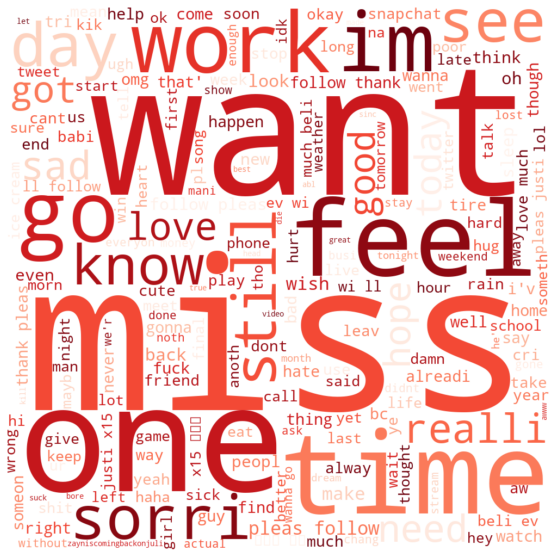

In [ ]:
# Polarity == 0 negative
train_s0 = df_full[df_full.sentiment ==0]

all_text = ' '.join(word for word in train_s0.tweet_proc)
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

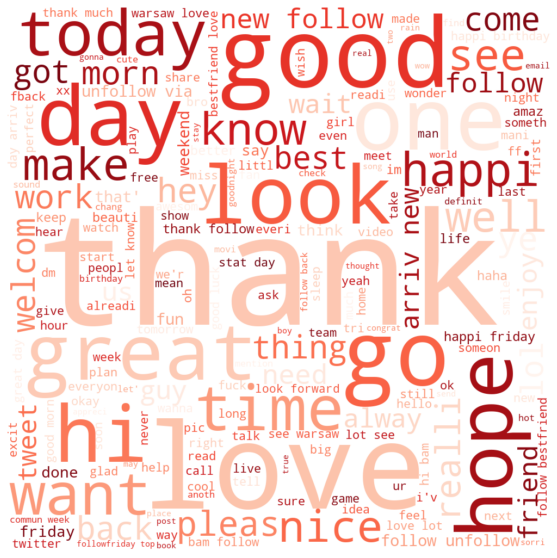

In [ ]:
# Polarity == 1 positive
train_s1 = df_full[df_full.sentiment ==1]

all_text1 = ' '.join(word for word in train_s1.tweet_proc)
wordcloud1 = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text1)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
#creating test and train set for X and y
msk = np.random.rand(len(df_full)) < 0.8
train_df = df_full[msk]
test_df = df_full[~msk]

X_train = train_df['tweet_proc'].reset_index(drop=True)
y_train = train_df['sentiment'].reset_index(drop=True)
X_test = test_df['tweet_proc'].reset_index(drop=True)
y_test = test_df['sentiment'].reset_index(drop=True)
#set up baseline 
print(y_train.value_counts(normalize=True))
baseline = 0.2

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

0.0    0.503705
1.0    0.496295
Name: sentiment, dtype: float64
(7963,)
(7963,)
(2037,)
(2037,)


In [ ]:
#creating objects of count-vectorizer and tfidf vectorizer
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [ ]:
# Word ngram vector
train_vect = vect_word.fit_transform(X_train[0:])
test_vect = vect_word.transform(X_test[0:])

# Character n gram vector
train_vect_char = vect_char.fit_transform(X_train[0:])
test_vect_char = vect_char.transform(X_test[0:])


In [ ]:
X = sparse.hstack([train_vect, train_vect_char])
x_test = sparse.hstack([test_vect, test_vect_char])
x_test.shape

(2037, 60000)

### Model building

In [ ]:
lr_word = LogisticRegression(C=2,random_state = 32,class_weight = 'balanced')
lr_word.fit(train_vect,y_train)
prd = lr_word.predict_proba(test_vect)[:,1]

lr_char = LogisticRegression(C=2,random_state = 32,class_weight = 'balanced')
lr_char.fit(train_vect_char,y_train)
prd_char = lr_char.predict_proba(test_vect_char)[:,1]

lr_comp = LogisticRegression(C=2,random_state = 32,class_weight = 'balanced')
lr_comp.fit(X,y_train)
prd_comp = lr_comp.predict_proba(x_test)[:,1]


##Model Validation on train data set

In [ ]:
pred_word =  lr_word.predict(train_vect)
print('\nConfusion matrix\n',confusion_matrix(y_train,pred_word))
print(classification_report(y_train,pred_word))

pred_char =  lr_char.predict(train_vect_char)
print('\nConfusion matrix\n',confusion_matrix(y_train,pred_char))
print(classification_report(y_train,pred_char))

pred_comp =  lr_comp.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y_train,pred_comp))
print(classification_report(y_train,pred_comp))


Confusion matrix
 [[3794  217]
 [ 419 3533]]
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      4011
         1.0       0.94      0.89      0.92      3952

    accuracy                           0.92      7963
   macro avg       0.92      0.92      0.92      7963
weighted avg       0.92      0.92      0.92      7963


Confusion matrix
 [[3974   37]
 [   3 3949]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      4011
         1.0       0.99      1.00      0.99      3952

    accuracy                           0.99      7963
   macro avg       0.99      1.00      0.99      7963
weighted avg       1.00      0.99      0.99      7963


Confusion matrix
 [[4006    5]
 [  31 3921]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4011
         1.0       1.00      0.99      1.00      3952

    accuracy                           1.00 

##Model Validation on test data set

In [ ]:
pred_word_test =  lr_word.predict(test_vect)
print("Word Tfidf")
print('\nConfusion matrix\n',confusion_matrix(y_test,pred_word_test))
print(classification_report(y_test,pred_word_test))
print("\n")

pred_char_test =  lr_char.predict(test_vect_char)
print("Char tfidf")
print('\nConfusion matrix\n',confusion_matrix(y_test,pred_char_test))
print(classification_report(y_test,pred_char_test))
print("\n")

pred_test_comp =  lr_comp.predict(x_test)
print("Word and Char tfidf")
print('\nConfusion matrix\n',confusion_matrix(y_test,pred_test_comp))
print(classification_report(y_test,pred_test_comp))
print("\n")

Word Tfidf

Confusion matrix
 [[776 213]
 [300 748]]
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       989
         1.0       0.78      0.71      0.74      1048

    accuracy                           0.75      2037
   macro avg       0.75      0.75      0.75      2037
weighted avg       0.75      0.75      0.75      2037



Char tfidf

Confusion matrix
 [[ 966   23]
 [  16 1032]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       989
         1.0       0.98      0.98      0.98      1048

    accuracy                           0.98      2037
   macro avg       0.98      0.98      0.98      2037
weighted avg       0.98      0.98      0.98      2037



Word and Char tfidf

Confusion matrix
 [[960  29]
 [ 53 995]]
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       989
         1.0       0.97      0.95      0.96      1048

    ac

##ROC curve

Text(0.5, 1.0, 'Reciever Operating Characteristic')

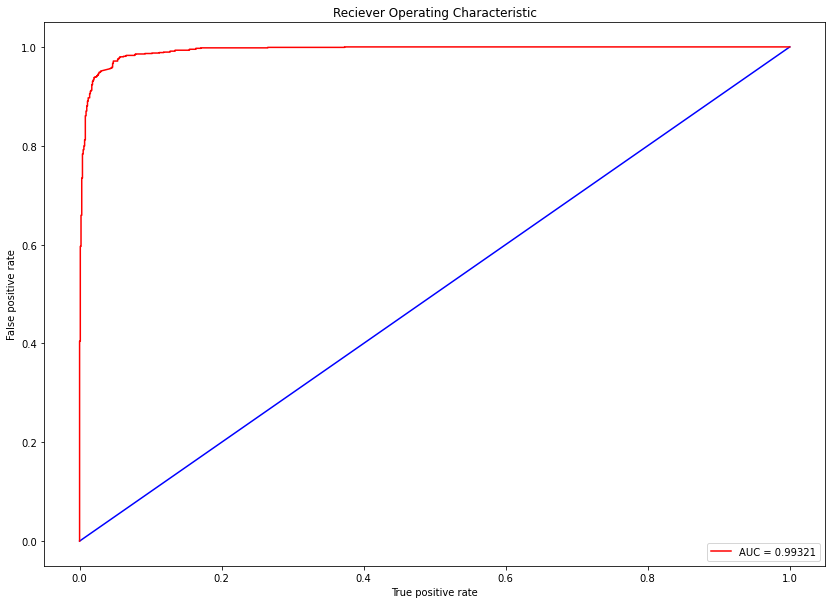

In [ ]:
pred_pro = lr_comp.predict_proba(x_test)[:,1]
frp,trp,thres = roc_curve(y_test,pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.5f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')



Text(0.5, 1.0, 'Reciever Operating Characteristic')

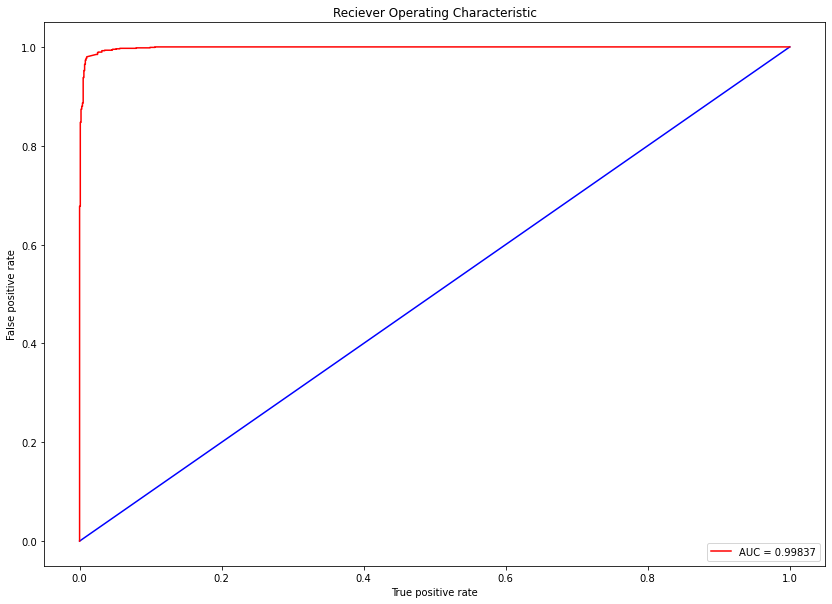

In [ ]:
pred_pro = lr_char.predict_proba(test_vect_char)[:,1]
frp,trp,thres = roc_curve(y_test,pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.5f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')


##Printing predictions of Tweets

In [ ]:
#pred_word_test
#pred_char_test
#pred_test_comp

pred_word_test[0:5]

array([1., 0., 1., 0., 0.])

In [ ]:
print("Predicted --","Actual --","Tweet","--","Processed Tweet")
for i in range(0,5):
  print(pred_word_test[i],"--",test_df.iloc[i,1],"--",test_df.iloc[i,0],"--",test_df.iloc[i,2])

Predicted -- Actual -- Tweet -- Processed Tweet
1.0 -- 1.0 -- Thank you. Have a lovely weekend everyone. :-)) https://t.co/1CcpcLlzic -- thank love weekend everyon :-)
0.0 -- 0.0 -- Hateeeee time apart :( -- hatee time apart :(
1.0 -- 0.0 -- Freaking humidity!! I think I never get used to it even I'm 100% Japanese. :( -- freak humid think never get use even i'm 100 japanes :(
0.0 -- 1.0 -- @acasorguk PICK ME PLEASE! :) http://t.co/2Kjd6ACp1S -- pick pleas :)
0.0 -- 0.0 -- .@aylesburyowl @ljam185 The facade of democracy has dropped so quickly :( -- facad democraci drop quickli :(


In [ ]:
print("Predicted --","Actual --","Tweet","--","Processed Tweet")
for i in range(0,5):
  print(pred_char_test[i],"--",test_df.iloc[i,1],"--",test_df.iloc[i,0],"--",test_df.iloc[i,2])

Predicted -- Actual -- Tweet -- Processed Tweet
1.0 -- 1.0 -- Thank you. Have a lovely weekend everyone. :-)) https://t.co/1CcpcLlzic -- thank love weekend everyon :-)
0.0 -- 0.0 -- Hateeeee time apart :( -- hatee time apart :(
0.0 -- 0.0 -- Freaking humidity!! I think I never get used to it even I'm 100% Japanese. :( -- freak humid think never get use even i'm 100 japanes :(
1.0 -- 1.0 -- @acasorguk PICK ME PLEASE! :) http://t.co/2Kjd6ACp1S -- pick pleas :)
0.0 -- 0.0 -- .@aylesburyowl @ljam185 The facade of democracy has dropped so quickly :( -- facad democraci drop quickli :(


In [ ]:
test_df.head()

,tweet,sentiment,tweet_proc
0,Thank you. Have a lovely weekend everyone. :-)...,1.0,thank love weekend everyon :-)
13,Hateeeee time apart :(,0.0,hatee time apart :(
16,Freaking humidity!! I think I never get used t...,0.0,freak humid think never get use even i'm 100 j...
20,@acasorguk PICK ME PLEASE! :) http://t.co/2Kjd...,1.0,pick pleas :)
26,.@aylesburyowl @ljam185 The facade of democrac...,0.0,facad democraci drop quickli :(


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy for word TFIDF features --",accuracy_score(test_df.iloc[:,1], pred_word_test))
print("Accuracy for char TFIDF features --",accuracy_score(test_df.iloc[:,1], pred_char_test))
print("Accuracy for word-char stack features TFIDF --",accuracy_score(test_df.iloc[:,1], pred_test_comp))

Accuracy for word TFIDF features -- 0.748159057437408
Accuracy for char TFIDF features -- 0.9808541973490427
Accuracy for word-char stack features TFIDF -- 0.9597447226313206


In [ ]:
import requests
import json

In [ ]:

def url_func(team,year,page_no,team_no):
  url = "https://jsonmock.hackerrank.com/api/football_matches?year=" + str(year) + "&" + team_no + "=" + str(team) + "&page=" + str(page_no)
  cont = json.loads(requests.get(url).content)["data"]
  goals = 0.0
  for val in cont:
    if val[team_no] == team:
      search_index = team_no + "goals"
      goals = goals + float(val[search_index])
  return goals

for row in [[2011,'AC Milan'],[2012,'AC Milan'],[2013,'AC Milan'],[2011,'Barcelona'],[2012,'Barcelona'],[2013,'Barcelona']]:
  year = row[0]
  team = row[1]
  page_no = 1
  home = "https://jsonmock.hackerrank.com/api/football_matches?year=" + str(year) + "&team1=" + str(team) + "&page=" + str(page_no)
  away = "https://jsonmock.hackerrank.com/api/football_matches?year=" + str(year) + "&team2=" + str(team) + "&page=" + str(page_no)
  rhome = requests.get(home)
  raway = requests.get(away)
  pages_home = json.loads(rhome.content)["total_pages"]
  pages_away = json.loads(rhome.content)["total_pages"]

  totgoals = 0.0
  for i in range(1,pages_home+1):
    hgoals = url_func(team,year,pages_home,"team1")
    agoals = url_func(team,year,pages_away,"team2")
    totgoals = totgoals + hgoals + agoals

  print(team,year,totgoals)


AC Milan 2011 42.0
AC Milan 2012 33.0
AC Milan 2013 27.0
Barcelona 2011 35.0
Barcelona 2012 18.0
Barcelona 2013 21.0


In [ ]:
import json

for iter in json.loads(r.content)["data"]:
  if iter['team2']=='AC Milan':
    print(iter['team1goals'])

2
1
2
3
3
0
3
2
3
2


In [ ]:
for iter in json.loads(r.content)["data"]:
  print(iter)

{'competition': 'UEFA Champions League', 'year': 2011, 'round': 'GroupH', 'team1': 'Barcelona', 'team2': 'AC Milan', 'team1goals': '2', 'team2goals': '2'}
{'competition': 'UEFA Champions League', 'year': 2011, 'round': 'GroupH', 'team1': 'BATE Borisov', 'team2': 'AC Milan', 'team1goals': '1', 'team2goals': '1'}
{'competition': 'UEFA Champions League', 'year': 2011, 'round': 'GroupH', 'team1': 'Viktoria Plzen', 'team2': 'AC Milan', 'team1goals': '2', 'team2goals': '2'}
{'competition': 'UEFA Champions League', 'year': 2011, 'round': 'R16', 'team1': 'Arsenal', 'team2': 'AC Milan', 'team1goals': '3', 'team2goals': '0'}
{'competition': 'UEFA Champions League', 'year': 2011, 'round': 'QF', 'team1': 'Barcelona', 'team2': 'AC Milan', 'team1goals': '3', 'team2goals': '1'}
{'competition': 'Serie A', 'year': 2011, 'round': '', 'team1': 'Cagliari Calcio', 'team2': 'AC Milan', 'team1goals': '0', 'team2goals': '2'}
{'competition': 'Serie A', 'year': 2011, 'round': '', 'team1': 'SSC Napoli', 'team2':

In [ ]:
r.content

b'{"page":"1","per_page":10,"total":24,"total_pages":3,"data":[{"competition":"UEFA Champions League","year":2011,"round":"GroupH","team1":"Barcelona","team2":"AC Milan","team1goals":"2","team2goals":"2"},{"competition":"UEFA Champions League","year":2011,"round":"GroupH","team1":"BATE Borisov","team2":"AC Milan","team1goals":"1","team2goals":"1"},{"competition":"UEFA Champions League","year":2011,"round":"GroupH","team1":"Viktoria Plzen","team2":"AC Milan","team1goals":"2","team2goals":"2"},{"competition":"UEFA Champions League","year":2011,"round":"R16","team1":"Arsenal","team2":"AC Milan","team1goals":"3","team2goals":"0"},{"competition":"UEFA Champions League","year":2011,"round":"QF","team1":"Barcelona","team2":"AC Milan","team1goals":"3","team2goals":"1"},{"competition":"Serie A","year":2011,"round":"","team1":"Cagliari Calcio","team2":"AC Milan","team1goals":"0","team2goals":"2"},{"competition":"Serie A","year":2011,"round":"","team1":"SSC Napoli","team2":"AC Milan","team1goals"